<a href="https://colab.research.google.com/github/kunai-3txk/colab/blob/main/20220526_Phone_recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

import itertools
import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
df = pd.read_csv(f"/content/drive/MyDrive/Dev/Phone_Recommend.csv")
df.head()

,old,Tel,zokugara,layer,sex,Tel_Detail,y
0,70,0,0,rock,0,None,1
1,70,0,1,rock,1,None,1
2,60,1,1,rock,1,Negative,0
3,40,1,2,rock,1,Negative,0
4,70,1,0,float,0,Positive,1


In [15]:
df.describe()

,old,Tel,zokugara,sex,y
count,667.000000,667.000000,667.000000,667.000000,667.000000
mean,64.662669,0.673163,0.562219,0.575712,0.259370
std,6.953201,0.469409,0.567074,0.494605,0.438618
min,40.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,1.000000,1.000000,1.000000,0.000000
75%,70.000000,1.000000,1.000000,1.000000,1.000000
max,70.000000,1.000000,2.000000,1.000000,1.000000


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#train_columns = ['old','sex','layer','Tel_Detail']
train_columns = ['layer','Tel_Detail']
X = df[train_columns]
X = pd.get_dummies(X, drop_first=True)

y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # 80%のデータを学習データに、20%を検証データにする


LogisticRegression()

まずはロジスティック回帰で傾向確認

---



In [ ]:
model = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
model.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習

In [32]:
X.head()

,old,sex,layer_rock,Tel_Detail_None,Tel_Detail_Positive
0,70,0,1,1,0
1,70,1,1,1,0
2,60,1,1,0,0
3,40,1,1,0,0
4,70,0,0,0,1


In [34]:
# 訓練データの正解率
train_score = format(model.score(X_train, y_train))
print('正解率(train):', train_score)

# テストデータの正解率
test_score = format(model.score(X_test, y_test))
print('正解率(test):', test_score)

正解率(train): 0.8574108818011257
正解率(test): 0.7611940298507462


In [35]:
# 学習済みモデルの各変数の係数を取得
regression_coefficient = model.coef_

# 行ラベル･列ラベルを付与してDataFrameに変換
pd.DataFrame(regression_coefficient.T,
             index = [X.columns.values],
             columns = ['回帰係数'])

,回帰係数
layer_rock,-2.196021
Tel_Detail_None,1.271938
Tel_Detail_Positive,2.894565


https://qiita.com/0NE_shoT_/items/286a99d66cf6d3aaccf0

傾向スコアの推定
共変量から各ユーザーの傾向スコアを推定します。ここでは、StatsModelsライブラリのLogit関数を使い、ロジスティック回帰により傾向スコア推定モデルを構築します。

---



In [51]:
train_columns = ['old','sex','layer']
X = df[train_columns]
X = pd.get_dummies(X, drop_first=True)
X['old']=X['old']/10
Z = df['Tel']
y = df['y']

In [52]:
X.head()

,old,sex,layer_rock
0,7.0,0,1
1,7.0,1,1
2,6.0,1,1
3,4.0,1,1
4,7.0,0,0


In [53]:
exog = sm.add_constant(X) # 切片の追加
logit_model = sm.Logit(endog=Z, exog=exog) # ロジスティック回帰
logit_res = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.623656
         Iterations 5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


傾向スコアの推定精度の確認
下記のコードで推定精度を見てみると、AUC=XXXでした。まずまずの推定精度といったところです。

---



In [54]:
ps = logit_res.predict(exog)
print('AUC = {:.3f}'.format(roc_auc_score(y_true=Z, y_score=ps)))
# 出力：=> AUC = 0.792

AUC = 0.573


さらに下記のコードで、キャリブレーションプロットを描画してみます。キャリブレーションプロットがおおむね45度線に乗っているので、やはりまずまずの推定精度です。

---



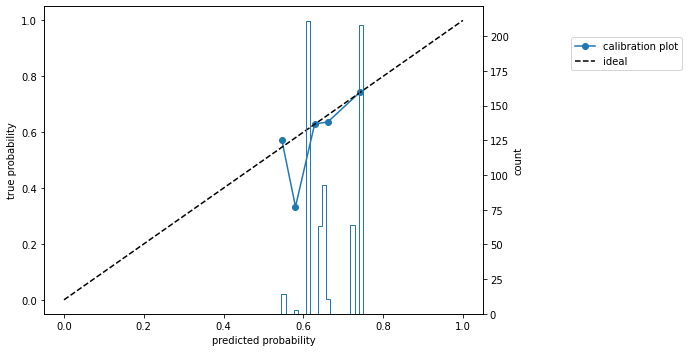

In [55]:
_, ax1 = plt.subplots(figsize=(10, 5))

prob_true, prob_pred = calibration_curve(y_true=Z, y_prob=ps, n_bins=20)
ax1.plot(prob_pred, prob_true, marker='o', label='calibration plot')
ax1.plot([0,1], [0,1], linestyle='--', color='black', label='ideal')
ax1.legend(bbox_to_anchor=(1.2, 0.9), loc='upper left', borderaxespad=0)
ax1.set_xlabel('predicted probability')
ax1.set_ylabel('true probability')

ax2 = ax1.twinx()
ax2.hist(ps, bins=20, histtype='step', rwidth=0.9)
ax2.set_ylabel('count')
plt.tight_layout()
plt.show()

ATTの推定
ATTを推定します。推定対象の結果変数は、アプリ利用ダミー変数（アプリ利用があれば1、なければ0をとる変数）です。下記のコードでATTを推定すると、CMによる効果は0.026（±0.013はブートストラップ法で算出した95％信頼区間）程度でとなりました。つまり、CM施策により、アプリを利用するユーザーの割合が2.6%程度増加することがわかりました。（岩波DS vol.3に記載の値と合致していることは確認済み）

---



In [56]:
sample_size = len(df.loc[df['Tel']==1])
ATT_list = []

for i in range(10000):
    idx1 = pd.Series(df.loc[df['Tel']==1, 'y'].index).sample(n=sample_size, replace=True, random_state=i)
    idx0 = pd.Series(df.loc[df['Tel']==0, 'y'].index).sample(n=sample_size, replace=True, random_state=i)

    Z_tmp = np.r_[Z[idx1], Z[idx0]]
    Y_tmp = np.r_[y[idx1], y[idx0]]
    ps_tmp = np.r_[ps[idx1], ps[idx0]]
    w01_tmp = (1-Z_tmp)*ps_tmp/(1-ps_tmp)

    E1 = np.mean(Y_tmp[Z_tmp==1])
    E0 = np.sum(Y_tmp * w01_tmp) / np.sum(w01_tmp)
    ATT = E1 - E0
    ATT_list.append(ATT)

print('ATT = {:.3f} ± {:.3f} (s.d.={:.3f})'.format(np.mean(ATT_list), np.std(ATT_list)*1.96, np.std(ATT_list)))

ATT = 0.069 ± 0.059 (s.d.=0.030)


共変量の分布の確認

---



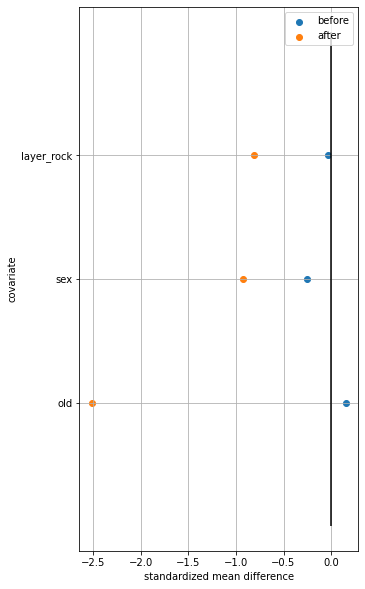

In [57]:
def standardized_mean_difference(X1, X0): # SMDを計算する関数
    N1 = len(X1)
    N0 = len(X0)
    s_pool = ((N1-1)*np.var(X1)+(N0-1)*np.var(X0))/(N1+N0-2)

    return (np.mean(X1)-np.mean(X0))/np.sqrt(s_pool)

def smd_on_the_treated(X, Z, ps): # 傾向スコアを用いた調整前後のSMDを計算する関数
    X1 = X[Z==1]
    X0 = X[Z==0]
    ps0 = ps[Z==0]
    X10 = X0*ps0/(1-ps0)

    smd_before = standardized_mean_difference(X1, X0)
    smd_after = standardized_mean_difference(X1, X10)

    return smd_before, smd_after

# 各共変量について、傾向スコアを用いた調整前後のSMDを計算する
smd_list = []
for name in X.columns:
    smd_before, smd_after = smd_on_the_treated(X=X[name], Z=Z, ps=ps)
    smd_list.append([name, smd_before, smd_after])
smd_df = pd.DataFrame(smd_list, columns=['covariate', 'SMD(before)', 'SMD(after)'])

# 各共変量について、傾向スコアを用いた調整前後のSMDをプロットする（love plotを作成する）
plt.figure(figsize=(5, 10))
plt.scatter(smd_df['SMD(before)'], smd_df['covariate'], label='before')
plt.scatter(smd_df['SMD(after)'], smd_df['covariate'], label='after')
plt.vlines([0], ymin=-1, ymax=X.shape[1])
plt.legend()
plt.xlabel('standardized mean difference')
plt.ylabel('covariate')
plt.grid(True)
plt.show()